In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras
from tensorflow.keras import backend as k
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import glob
import numpy as np
import json

In [3]:
def get_datagen():    
    datagen = ImageDataGenerator(
        #rescale=1./255,
        rotation_range=16,
        width_shift_range=0.1,
        height_shift_range=0.1,
#         horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.1
    )
    test_datagen = ImageDataGenerator(
        #rescale=1./255,
    )
    return datagen,test_datagen

In [4]:
def get_data(train_datagen,test_datagen):
    train_it = train_datagen.flow_from_directory('Splitted_Dataset_2/train', class_mode='categorical',target_size=(224, 224))

    test_it = test_datagen.flow_from_directory('Splitted_Dataset_2/test', class_mode='categorical',target_size=(224, 224))
    return train_it,test_it

In [5]:
datagen,test_datagen=get_datagen()
train_it,test_it=get_data(datagen,test_datagen)

Found 1610 images belonging to 52 classes.
Found 264 images belonging to 52 classes.


In [6]:
def get_vgg():
    vgg19 = tf.keras.applications.vgg19
    vgg = vgg19.VGG19(weights='imagenet',include_top=False,input_shape=(224,224,3))
    print(vgg.summary())
    return vgg

In [7]:
def get_DenseNet201():
    from tensorflow.keras.applications import DenseNet201
    vgg = DenseNet201(weights='imagenet',include_top=False,input_shape=(224,224,3),pooling='avg')
    for i in range(0,len(vgg.layers)-20):
        vgg.layers[i].trainable = False
    vgg.summary()
    return vgg

In [8]:
def get_model(vgg): 
    
    x = tf.keras.layers.Flatten()(vgg.output)
    # three hidden layers
    x = tf.keras.layers.Dense(256, activation='selu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    # final softmax layer with two categories (dog and cat)
    predictions = tf.keras.layers.Dense(52, activation='softmax')(x)
    model = tf.keras.Model(inputs=vgg.input,outputs=predictions)
    model.summary()
    return model


In [9]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
def train(ep):
    model = get_DenseNet201()
    model=get_model(model)
    model.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adamax(),
                      metrics=['acc'])
    history = model.fit(train_it, epochs = ep,steps_per_epoch=16, validation_data=test_it, validation_steps=8)
    return model,history

In [11]:
def save_model(model):
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")

In [37]:
def get_model():
    #Reading the model from JSON file
    with open('model.json', 'r') as json_file:
        json_savedModel= json_file.read()

    
    model = tf.keras.models.model_from_json(json_savedModel)
    model.load_weights('model.h5')
    return model

In [12]:
model,history = train(50)

74836368/74836368 [==============================] - 22s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                      

                                                                                                  
 conv2_block4_0_relu (Activatio  (None, 56, 56, 160)  0          ['conv2_block4_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv3_block6_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
          

                                                                                                  
 conv3_block10_concat (Concaten  (None, 28, 28, 448)  0          ['conv3_block9_concat[0][0]',    
 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 32)   36864       ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block7_0_relu (Activatio  (None, 14, 14, 448)  0          ['conv4_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block15_concat (Concaten  (None, 14, 14, 736)  0          ['conv4_block14_concat[0][0]',   
 ate)                                                             'conv4_block15_2_conv[0][0]']   
                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block24_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 14, 14, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
          

                                                                                                  
 conv4_block29_0_bn (BatchNorma  (None, 14, 14, 1152  4608       ['conv4_block28_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 14, 14, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 14, 14, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)

 conv4_block33_1_conv (Conv2D)  (None, 14, 14, 128)  163840      ['conv4_block33_0_relu[0][0]']   
                                                                                                  
 conv4_block33_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block33_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block37_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block37_1_relu[0][0]']   
                                                                                                  
 conv4_block37_concat (Concaten  (None, 14, 14, 1440  0          ['conv4_block36_concat[0][0]',   
 ate)                           )                                 'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 14, 14, 1440  5760       ['conv4_block37_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 14, 14, 1440  0          ['conv4_block38_0_bn[0][0]']     
 on)      

 lization)                      )                                                                 
                                                                                                  
 conv4_block42_0_relu (Activati  (None, 14, 14, 1568  0          ['conv4_block42_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 14, 14, 128)  200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block46_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block46_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block46_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block46_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 14, 14, 1728  0          ['conv4_block45_concat[0][0]',   
 ate)                           )                                 'conv4_block46_2_conv[0][0]']   
          

                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 128)    118784      ['conv5_block2_0_relu[0][0]']    
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block2_1_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv5_block6_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block6_1_relu[0][0]']    
                                                                                                  
 conv5_block6_concat (Concatena  (None, 7, 7, 1088)  0           ['conv5_block5_concat[0][0]',    
 te)                                                              'conv5_block6_2_conv[0][0]']    
                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 7, 7, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block11_0_bn (BatchNorma  (None, 7, 7, 1216)  4864        ['conv5_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_0_relu (Activati  (None, 7, 7, 1216)  0           ['conv5_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, 7, 7, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv5_block15_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block15_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block15_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 7, 7, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)     

 conv5_block19_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block19_1_relu[0][0]']   
                                                                                                  
 conv5_block19_concat (Concaten  (None, 7, 7, 1504)  0           ['conv5_block18_concat[0][0]',   
 ate)                                                             'conv5_block19_2_conv[0][0]']   
                                                                                                  
 conv5_block20_0_bn (BatchNorma  (None, 7, 7, 1504)  6016        ['conv5_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 7, 7, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block24_0_relu (Activati  (None, 7, 7, 1632)  0           ['conv5_block24_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_1_conv (Conv2D)  (None, 7, 7, 128)    208896      ['conv5_block24_0_relu[0][0]']   
                                                                                                  
 conv5_block24_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block28_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block28_1_relu[0][0]']   
                                                                                                  
 conv5_block28_concat (Concaten  (None, 7, 7, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block32_concat (Concaten  (None, 7, 7, 1920)  0           ['conv5_block31_concat[0][0]',   
 ate)                                                             'conv5_block32_2_conv[0][0]']   
                                                                                                  
 bn (BatchNormalization)        (None, 7, 7, 1920)   7680        ['conv5_block32_concat[0][0]']   
                                                                                                  
 relu (Activation)              (None, 7, 7, 1920)   0           ['bn[0][0]']                     
                                                                                                  
 avg_pool (GlobalAveragePooling  (None, 1920)        0           ['relu[0][0]']                   
 2D)                                                                                              
                                                                                                  
Total para

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 32)   36864       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_concat (Concatena  (None, 56, 56, 160)  0          ['conv2_block2_concat[0][0]',    
 te)                                                              'conv2_block3_2_conv[0][0]']    
                                                                                                  
 conv2_block4_0_bn (BatchNormal  (None, 56, 56, 160)  640        ['conv2_block3_concat[0][0]']    
 ization) 

 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_block1_concat (Concatena  (None, 28, 28, 160)  0          ['pool2_pool[0][0]',             
 te)                                                              'conv3_block1_2_conv[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block5_concat (Concatena  (None, 28, 28, 288)  0          ['conv3_block4_concat[0][0]',    
 te)                                                              'conv3_block5_2_conv[0][0]']    
                                                                                                  
 conv3_block6_0_bn (BatchNormal  (None, 28, 28, 288)  1152       ['conv3_block5_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block6_0_relu (Activatio  (None, 28, 28, 288)  0          ['conv3_block6_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_1_conv (Conv2D)   (None, 28, 28, 128)  36864       ['conv3_block6_0_relu[0][0]']    
          

 on)                                                                                              
                                                                                                  
 conv3_block10_1_conv (Conv2D)  (None, 28, 28, 128)  53248       ['conv3_block10_0_relu[0][0]']   
                                                                                                  
 conv3_block10_1_bn (BatchNorma  (None, 28, 28, 128)  512        ['conv3_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block10_1_relu (Activati  (None, 28, 28, 128)  0          ['conv3_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_blo

 conv4_block2_0_relu (Activatio  (None, 14, 14, 288)  0          ['conv4_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 14, 14, 128)  36864       ['conv4_block2_0_relu[0][0]']    
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 14, 14, 32)   36864       ['conv4_block6_1_relu[0][0]']    
                                                                                                  
 conv4_block6_concat (Concatena  (None, 14, 14, 448)  0          ['conv4_block5_concat[0][0]',    
 te)                                                              'conv4_block6_2_conv[0][0]']    
                                                                                                  
 conv4_block7_0_bn (BatchNormal  (None, 14, 14, 448)  1792       ['conv4_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv4_block10_2_conv[0][0]']   
                                                                                                  
 conv4_block11_0_bn (BatchNorma  (None, 14, 14, 576)  2304       ['conv4_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block11_0_relu (Activati  (None, 14, 14, 576)  0          ['conv4_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_1_conv (Conv2D)  (None, 14, 14, 128)  73728       ['conv4_block11_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block15_1_conv (Conv2D)  (None, 14, 14, 128)  90112       ['conv4_block15_0_relu[0][0]']   
                                                                                                  
 conv4_block15_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block15_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block15_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block15_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block19_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block19_1_relu[0][0]']   
                                                                                                  
 conv4_block19_concat (Concaten  (None, 14, 14, 864)  0          ['conv4_block18_concat[0][0]',   
 ate)                                                             'conv4_block19_2_conv[0][0]']   
                                                                                                  
 conv4_block20_0_bn (BatchNorma  (None, 14, 14, 864)  3456       ['conv4_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block24_0_bn (BatchNorma  (None, 14, 14, 992)  3968       ['conv4_block23_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block24_0_relu (Activati  (None, 14, 14, 992)  0          ['conv4_block24_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block24_1_conv (Conv2D)  (None, 14, 14, 128)  126976      ['conv4_block24_0_relu[0][0]']   
                                                                                                  
 conv4_block24_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block24_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block28_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block28_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block28_1_relu[0][0]']   
                                                                                                  
 conv4_block28_concat (Concaten  (None, 14, 14, 1152  0          ['conv4_block27_concat[0][0]',   
 ate)     

 conv4_block32_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block32_1_relu[0][0]']   
                                                                                                  
 conv4_block32_concat (Concaten  (None, 14, 14, 1280  0          ['conv4_block31_concat[0][0]',   
 ate)                           )                                 'conv4_block32_2_conv[0][0]']   
                                                                                                  
 conv4_block33_0_bn (BatchNorma  (None, 14, 14, 1280  5120       ['conv4_block32_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block33_0_relu (Activati  (None, 14, 14, 1280  0          ['conv4_block33_0_bn[0][0]']     
 on)                            )                                                                 
          

                                                                                                  
 conv4_block37_0_relu (Activati  (None, 14, 14, 1408  0          ['conv4_block37_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block37_1_conv (Conv2D)  (None, 14, 14, 128)  180224      ['conv4_block37_0_relu[0][0]']   
                                                                                                  
 conv4_block37_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block37_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block37_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block37_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block41_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block41_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block41_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block41_1_relu[0][0]']   
                                                                                                  
 conv4_block41_concat (Concaten  (None, 14, 14, 1568  0          ['conv4_block40_concat[0][0]',   
 ate)                           )                                 'conv4_block41_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block45_concat (Concaten  (None, 14, 14, 1696  0          ['conv4_block44_concat[0][0]',   
 ate)                           )                                 'conv4_block45_2_conv[0][0]']   
                                                                                                  
 conv4_block46_0_bn (BatchNorma  (None, 14, 14, 1696  6784       ['conv4_block45_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block46_0_relu (Activati  (None, 14, 14, 1696  0          ['conv4_block46_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block46_1_conv (Conv2D)  (None, 14, 14, 128)  217088      ['conv4_block46_0_relu[0][0]']   
          

                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_concat (Concatena  (None, 7, 7, 928)   0           ['pool4_pool[0][0]',             
 te)                                                              'conv5_block1_2_conv[0][0]']    
                                                                                                  
 conv5_block2_0_bn (BatchNormal  (None, 7, 7, 928)   3712        ['conv5_block1_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_0_relu (Activatio  (None, 7, 7, 928)   0           ['conv5_block2_0_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv5_block6_0_relu (Activatio  (None, 7, 7, 1056)  0           ['conv5_block6_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block6_1_conv (Conv2D)   (None, 7, 7, 128)    135168      ['conv5_block6_0_relu[0][0]']    
                                                                                                  
 conv5_block6_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_blo

 conv5_block10_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block10_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block10_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block10_1_relu[0][0]']   
                                                                                                  
 conv5_block10_concat (Concaten  (None, 7, 7, 1216)  0           ['conv5_block9_concat[0][0]',    
 ate)                                                             'conv5_block10_2_conv[0][0]']   
          

                                                                                                  
 conv5_block14_concat (Concaten  (None, 7, 7, 1344)  0           ['conv5_block13_concat[0][0]',   
 ate)                                                             'conv5_block14_2_conv[0][0]']   
                                                                                                  
 conv5_block15_0_bn (BatchNorma  (None, 7, 7, 1344)  5376        ['conv5_block14_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block15_0_relu (Activati  (None, 7, 7, 1344)  0           ['conv5_block15_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block19_0_relu (Activati  (None, 7, 7, 1472)  0           ['conv5_block19_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block19_1_conv (Conv2D)  (None, 7, 7, 128)    188416      ['conv5_block19_0_relu[0][0]']   
                                                                                                  
 conv5_block19_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block19_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block19_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block19_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block23_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block23_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block23_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block23_1_relu[0][0]']   
                                                                                                  
 conv5_block23_concat (Concaten  (None, 7, 7, 1632)  0           ['conv5_block22_concat[0][0]',   
 ate)                                                             'conv5_block23_2_conv[0][0]']   
                                                                                                  
 conv5_block24_0_bn (BatchNorma  (None, 7, 7, 1632)  6528        ['conv5_block23_concat[0][0]']   
 lization)

 ate)                                                             'conv5_block27_2_conv[0][0]']   
                                                                                                  
 conv5_block28_0_bn (BatchNorma  (None, 7, 7, 1760)  7040        ['conv5_block27_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block28_0_relu (Activati  (None, 7, 7, 1760)  0           ['conv5_block28_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_1_conv (Conv2D)  (None, 7, 7, 128)    225280      ['conv5_block28_0_relu[0][0]']   
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block32_1_conv (Conv2D)  (None, 7, 7, 128)    241664      ['conv5_block32_0_relu[0][0]']   
                                                                                                  
 conv5_block32_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block32_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block32_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block32_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block32_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block32_1_relu[0][0]']   
          

16/16 [==============================] - 63s 4s/step - loss: 0.5831 - acc: 0.8652 - val_loss: 1.2021 - val_acc: 0.6250
Epoch 40/50
16/16 [==============================] - 58s 4s/step - loss: 0.5459 - acc: 0.8592 - val_loss: 1.0429 - val_acc: 0.6641
Epoch 41/50
16/16 [==============================] - 54s 3s/step - loss: 0.5784 - acc: 0.8469 - val_loss: 1.2495 - val_acc: 0.6211
Epoch 42/50
16/16 [==============================] - 56s 4s/step - loss: 0.5599 - acc: 0.8555 - val_loss: 1.0978 - val_acc: 0.6719
Epoch 43/50
16/16 [==============================] - 55s 3s/step - loss: 0.5563 - acc: 0.8714 - val_loss: 1.2050 - val_acc: 0.6328
Epoch 44/50
16/16 [==============================] - 56s 4s/step - loss: 0.5696 - acc: 0.8359 - val_loss: 1.2903 - val_acc: 0.5859
Epoch 45/50
16/16 [==============================] - 56s 4s/step - loss: 0.4913 - acc: 0.8594 - val_loss: 1.2156 - val_acc: 0.6211
Epoch 46/50
16/16 [==============================] - 55s 3s/step - loss: 0.4963 - acc: 0.8694 -

In [41]:
save_model(model)

In [42]:
model=get_model()

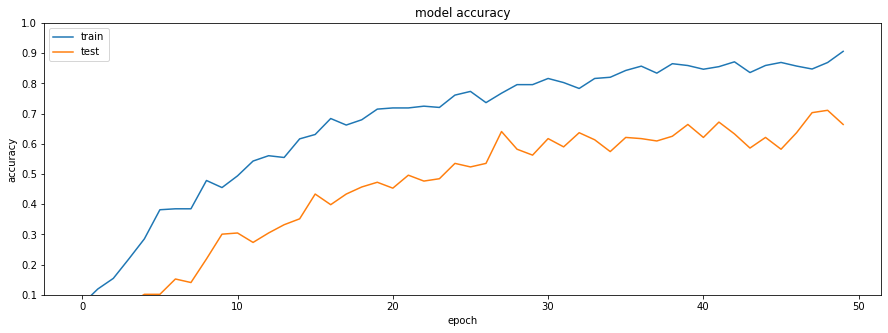

In [13]:
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.1,1)
plt.legend(['train', 'test'], loc='upper left')
plt.show()